# CIFAR-10 Classification using Keras & Tensorflow

**Welcome to this project!**

Here I'll implement a Convolutional Neural Network to classify the CIFAR-10 dataset.<br>
The CIFAR-10 dataset consists of 60 000 32x32 colour images in 10 classes, with 6 000 images per class.<br>
To get more info on this dataset check the tech report [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.<br>

For this classification task I'll be using Keras with Tensorflow backend.

## 1. Initial Setup

First things first. Let's set up all the resources, starting with the libraries.

### 1.1 Import libraries

In [1]:
import sys
import os
import time as time

import utils

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("tf")

Using TensorFlow backend.


### 1.2 Versions used in this project

In [2]:
print('OS:', sys.platform)
print('Python:', sys.version)
print('Tensorflow:', tf.__version__)
print('Keras:', keras.__version__)

OS: win32
Python: 3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]
Tensorflow: 1.12.0
Keras: 2.2.4


At first I trained the CNN on CPU and even though the CIFAR-10 is a small dataset by today's standards the training took a couple of hours. <br>

I then installed the GPU version of Tensorflow to check the training time difference.
If you don't have the GPU version installed you may check the Tensorflow installation page https://www.tensorflow.org/install/gpu.<br>

As stated below, I'm using my laptop GPU (GeForce GTX 1050 Ti).

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("You may want to install the GPU version of Tensorflow")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4792223871683692364
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3161430425
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18077346483931274172
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Default GPU Device: /device:GPU:0


### 1.3 Load Dataset

You can aither download the CIFAR-10 dataset directly from [here](https://www.cs.toronto.edu/~kriz/cifar.html) or import it using keras.datasets. <br>

For me the goal of this notebook is to get more experienced with the end-to-end process of developing a machine learning project therefore let's use the CIFAR-10 website to get it.<br>
Nevertheless you can simply use the code of the following cell to get the data.

```from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
n_train, n_channels, img_height, img_width =  X_train.shape
n_test, _, _, _ =  X_test.shape
n_classes = len(np.unique(train_labels))```

In case you use the previous cell you can skip to the next section.

To load the train and test sets I use the functions inside utils.py file. In section 1.1 you may see the corresponding import.<br>

The variables X_train and X_test contain the features (images), while the variables y_train and y_test contain the target class (class numbers). Furthermore, labels_train and labels_test contain the one-hot encoded array of class numbers.
I suggest you to check the utils.py file in order to understand how these objects are obtained from the CIFAR-10 website downloaded files.<br>

In [4]:
X_train, y_train, labels_train = utils.load_training_data();
X_test, y_test, labels_test = utils.load_test_data();

print('The shape of X_train is {}'.format(X_train.shape))
print('The shape of y_train is {}'.format(y_train.shape))
print('The shape of labels_train is {}'.format(labels_train.shape))
print('The shape of X_test is {}'.format(X_test.shape))
print('The shape of y_test is {}'.format(y_test.shape))
print('The shape of labels_test is {}'.format(labels_test.shape))

print('\nAfter loading CIFAR-10 there are {size} classified examples split into {train} train and {test} test examples.'
      .format(size=X_train.shape[0]+X_test.shape[0], train=X_train.shape[0], test=X_test.shape[0]))

The shape of X_train is (50000, 32, 32, 3)
The shape of y_train is (50000, 1)
The shape of labels_train is (50000, 10)
The shape of X_test is (10000, 32, 32, 3)
The shape of y_test is (10000, 1)
The shape of labels_test is (10000, 10)

After loading CIFAR-10 there are 60000 classified examples split into 50000 train and 10000 test examples.


In [5]:
#mean = np.mean(X_train)
#std = np.std(X_train)
#X_train=(X_train-mean)/std
#X_test=(X_test-mean)/std

To plot some images let's create a dict with the class number and its mapped name for each of the training set examples.

In [6]:
# The downloaded zip file from CIFAR-10 website also contains one file with label names 
class_labels = utils.load_classes()

# Create dict with class_label and respective number from 0 to 9
n_to_class = dict(zip(range(len(y_train)), class_labels))

print('The 10 distinct classes of CIFAR-10 are: \n {}'.format(n_to_class))

The 10 distinct classes of CIFAR-10 are: 
 {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


### 1.4 Set hyperparameters

In [7]:
# Number of training examples, images size (height, width, and number of channels)
n_train, img_height, img_width, n_channels = X_train.shape
#img_size_flat = img_height * img_width * n_channels

# Number of classes
n_classes = len(class_labels)

batchsize = 128
alpha = 0.01
momentum = 0.9
n_epoch = 10

GPU = True

### 1.5 Visualizing some training images

Let's check some examples in the training set.

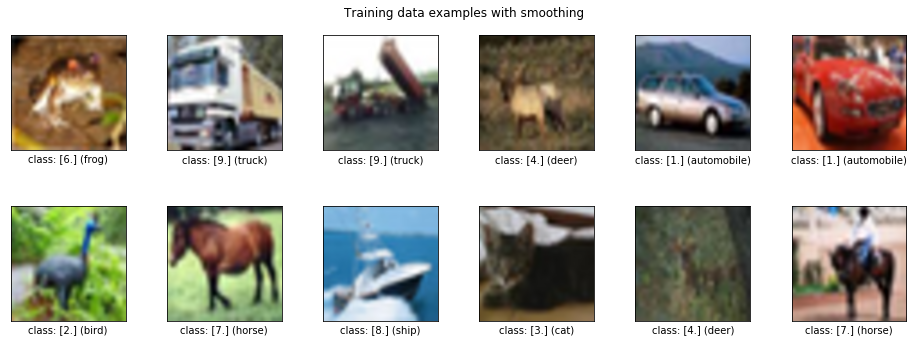

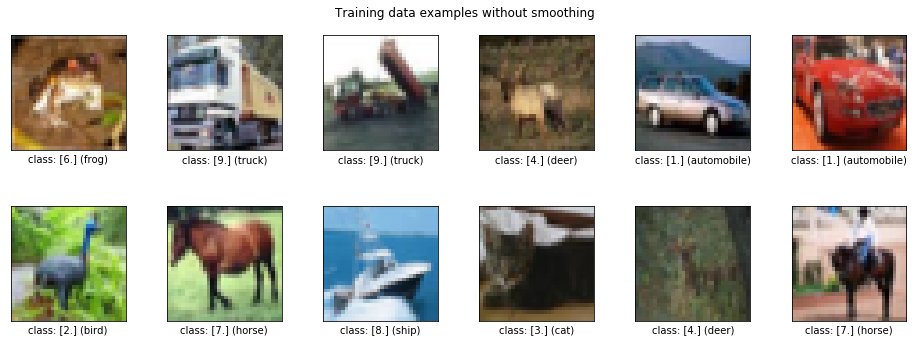

In [8]:
def plot_img(X_train, y_train, smooth=False):

    fig = plt.figure(figsize=(13, 5))
    for i in range(12):
        plt.subplot(2, 6, i+1)
        fig.subplots_adjust(hspace=0.5, wspace=0.5)
        if smooth:
            interpolation = 'spline16'
            title = 'Training data examples with smoothing'
        else:
            interpolation = 'nearest'
            title = 'Training data examples without smoothing'
        plt.tick_params(axis='both', which='both', bottom=False, top=False,
            left=False, right=False, labelbottom=False, labelleft=False)
        plt.imshow(X_train[i], interpolation=interpolation)
        plt.xlabel('class: {} ({})'.format(y_train[i], n_to_class[y_train[i, 0]]))

    plt.suptitle(title)
    plt.tight_layout()

plot_img(X_train, y_train, True)
plot_img(X_train, y_train, False)

## 2. Training

### 2.1 Define the CNN model

The Keras sequential model is a linear stack of layers.<br>
The model needs to know the expected input shape therefore the first layer of this Sequential model needs to get information about its input shape. You can do this by passing the input_shape argument. <br>

The human performance on the CIFAR-10 dataset is around 94% accuracy while state of the art approaches have already surpassed that value by showing an accuracy over 96%. You can find more about these results [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130). <br>

You may try different architectures with more layers or different optimizers.
Look at the link above and read the respective publications to get inspired. Just take note that training deeper networks (especially if you are not using GPU) will take longer.

In [9]:
# Model Definition
def getSimpleCNNModel():
    drop_dense = 0.5
    drop_conv = 0.25
    ac_layer = 'relu'
    model = Sequential()
    
    model.add(Convolution2D(48, (3, 3), padding='same', input_shape=(img_height, img_width, n_channels)))
    model.add(Activation(ac_layer))
    model.add(Convolution2D(48, (3, 3)))
    model.add(Activation(ac_layer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_conv))
    
    model.add(Convolution2D(96, (3, 3), padding='same'))
    model.add(Activation(ac_layer))
    model.add(Convolution2D(96, (3, 3)))
    model.add(Activation(ac_layer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_conv))
    
    model.add(Convolution2D(192, (3, 3), padding='same'))
    model.add(Activation(ac_layer))
    model.add(Convolution2D(192, (3, 3)))
    model.add(Activation(ac_layer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_conv))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation(ac_layer))
    model.add(Dropout(drop_dense))
    model.add(Dense(256))
    model.add(Activation(ac_layer))
    model.add(Dropout(drop_dense))
    model.add(Dense(n_classes, activation='softmax'))

    # Model Compilation
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Get model summary
    model.summary()
              
    return model

model1 = getSimpleCNNModel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 96)        41568     
__________

In [10]:
# build and compile the model  (roughly following the VGG paper)
def getSimpleCNNModel2():
    #reg = l2(1e-4)   # L2 or "ridge" regularisation
    reg = None
    num_filters = 32
    ac_layer = 'relu'
    adm = Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = adm
    drop_dense = 0.5
    drop_conv = 0

    model = Sequential()

    model.add(Convolution2D(num_filters, (3, 3), activation=ac_layer, kernel_regularizer=reg, input_shape=(img_height, img_width, n_channels),padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Convolution2D(num_filters, (3, 3), activation=ac_layer,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
    model.add(Dropout(drop_conv))

    model.add(Convolution2D(2*num_filters, (3, 3), activation=ac_layer,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Convolution2D(2*num_filters, (3, 3), activation=ac_layer,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
    model.add(Dropout(drop_conv))

    model.add(Convolution2D(4*num_filters, (3, 3), activation=ac_layer,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Convolution2D(4*num_filters, (3, 3), activation=ac_layer,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
    model.add(Dropout(drop_conv))

    model.add(Flatten())
    model.add(Dense(512, activation=ac_layer, kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Dropout(drop_dense))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # Get model summary
    model.summary()
    
    return model

model2 = getSimpleCNNModel2()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
__________

In [11]:
import cv2
X_train_resize = np.zeros((X_train.shape[0], 2*X_train.shape[1], 2*X_train.shape[2], X_train.shape[3]))
for i in range(len(X_train)):
    X_train_resize[i] = cv2.resize(X_train[i], (64, 64))

X_test_resize = np.zeros((X_test.shape[0], 2*X_test.shape[1], 2*X_test.shape[2], X_test.shape[3]))
for i in range(len(X_test)):
    X_test_resize[i] = cv2.resize(X_train[i], (64, 64))

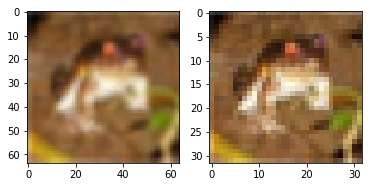

In [12]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
img_fin = cv2.resize(X_train_resize[0], (64, 64))
plt.imshow(img_fin)

plt.subplot(1, 2, 2)
plt.imshow(X_train[0])

In [19]:
#VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

def PretrainedVGG16(n_classes) :
    
    #load VGG16 model from keras
    #include_top = False to decrease overfitting
    vgg_16_model = VGG16(weights=None, include_top= False, input_shape=(2*img_height, 2*img_width, n_channels))
    vgg_16_model.summary()
    
    #get weights from pretrained model on imagenet
    vgg_16_model.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
        
    #Freeze all layers
    #for i in range(19):
     # vgg_16_model.layers[i].trainable = False
    
    #change model input layer according to cifar-10 dataset
    inputs = Input(shape = (2*img_height, 2*img_width, n_channels), name = 'image_input')
    
    #create dummy layer
    output_vgg16_model = vgg_16_model(inputs)
    
    #Add the fully-connected layers 
    #Adding one fully connected layer instead of 2 to decrease overfitting
    x = Flatten(name='flatten')(output_vgg16_model)
    x = Dense(2048, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(n_classes, activation='softmax', name='predictions')(x)

    #Create custom model
    model = Model(inputs=inputs, outputs=x)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
    model.summary()
    
    return model

model3 = PretrainedVGG16(n_classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

### 2.2 Helper functions 

For easier plotting of the model history, let's define helper functions to use later.

In [14]:
def plot_model_history(model_history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy Plot
    axes[0].plot(range(1, len(model_history.history['acc'])+1),model_history.history['acc'])
    axes[0].plot(range(1, len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_xticks(np.arange(1, len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axes[0].legend(['train', 'test'], loc='best')
    
    # Loss Plot
    axes[1].plot(range(1, len(model_history.history['loss'])+1),model_history.history['loss'])
    axes[1].plot(range(1, len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)
    axes[1].legend(['train', 'test'], loc='best')
    plt.show()

In [15]:
def accuracy(X_test, y_test, model):
    result = model.predict(X_test)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(y_test, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### 2.3 Train the model

Here is where the computations take place. Depending on wether it is being run on CPU or GPU, and how many epochs are defined, the following cell may take a long time to run.

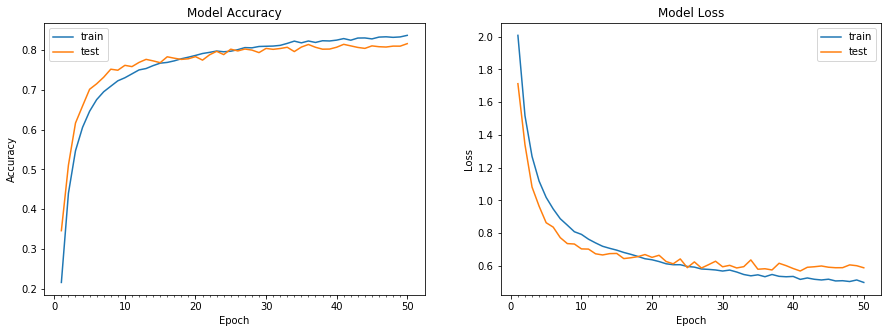

Training time: 1113.48 seconds
Accuracy on test data is 81.62


In [16]:
model = model1

# Model Training
start = time.time()
model_info = model.fit(X_train, labels_train, 
                       batch_size=64, epochs=50, 
                       validation_data = (X_test, labels_test), 
                       verbose=0)
end = time.time()

# Plot model history
plot_model_history(model_info)
print('Training time: %0.2f seconds'%(end - start))

# Compute test accuracy
print('Accuracy on test data is %0.2f'%accuracy(X_test, labels_test, model))

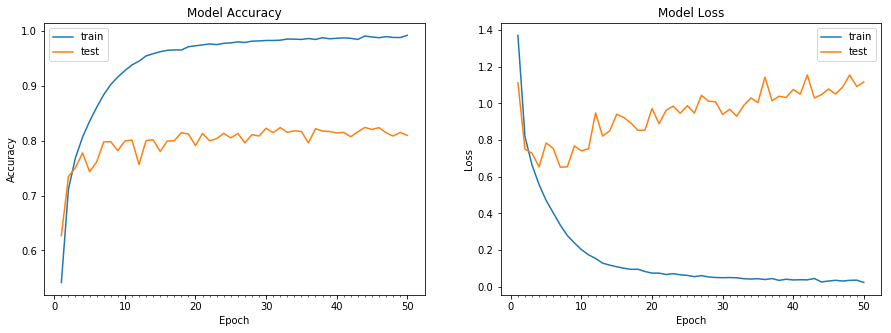

Training time: 1128.78 seconds
Accuracy on test data is 80.96


In [17]:
model = model2

# Model Training
start = time.time()
model_info = model.fit(X_train, labels_train, 
                       batch_size=64, epochs=50, 
                       validation_data = (X_test, labels_test), 
                       verbose=0)
end = time.time()

# Plot model history
plot_model_history(model_info)
print('Training time: %0.2f seconds'%(end - start))

# Compute test accuracy
print('Accuracy on test data is %0.2f'%accuracy(X_test, labels_test, model))

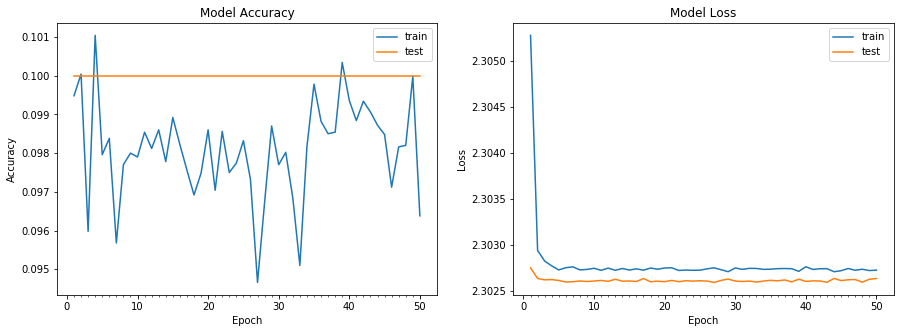

Training time: 9216.14 seconds
Accuracy on test data is 10.00


In [20]:
model = model3

# Model Training
start = time.time()
model_info = model.fit(X_train_resize, labels_train, 
                       batch_size=64, epochs=50, 
                       validation_data = (X_test_resize, labels_test), 
                       verbose=0)
end = time.time()

# Plot model history
plot_model_history(model_info)
print('Training time: %0.2f seconds'%(end - start))

# Compute test accuracy
print('Accuracy on test data is %0.2f'%accuracy(X_test_resize, labels_test, model))

### 2.2 Data Augmentation

To address overfitting and to make the most of a few training examples, a regular technique is to use data augmentation.<br>
In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class, which allows to
perform random transformations and normalization operations on training examples.<br>

To get a better view oh what this means I am taking the second example of the training set and check the outputs of the ImageDataGenerator.

In [21]:
# X_1 is the second example of the training set
X_1 = X_train[1]
display(X_1.shape)
X_1 = X_1.reshape((1,) + X_1.shape)
display(X_1.shape)

(32, 32, 3)

(1, 32, 32, 3)

To understand how are the examples in the dataset being augmented, let's define a plotting helper function to use later.

In [22]:
def plot_generated_img(X_train, smooth=False):
    fig = plt.figure(figsize=(12, 7))
    rows = 3
    cols = max(1, len(img_gen) // rows-1)
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i in range(len(img_gen)):
        subplot = fig.add_subplot(rows, cols+1, i+1)
        plt.tick_params(axis='both', which='both', bottom=False, top=False,
                        left=False, right=False, labelbottom=False, labelleft=False)
        plt.imshow(X_train[i][:,:,:], interpolation=interpolation)
    plt.suptitle('Generated images of the second example in the training set')
    plt.tight_layout()

Now let's see the output of the ImageDataGenerator for the second example of the training set.

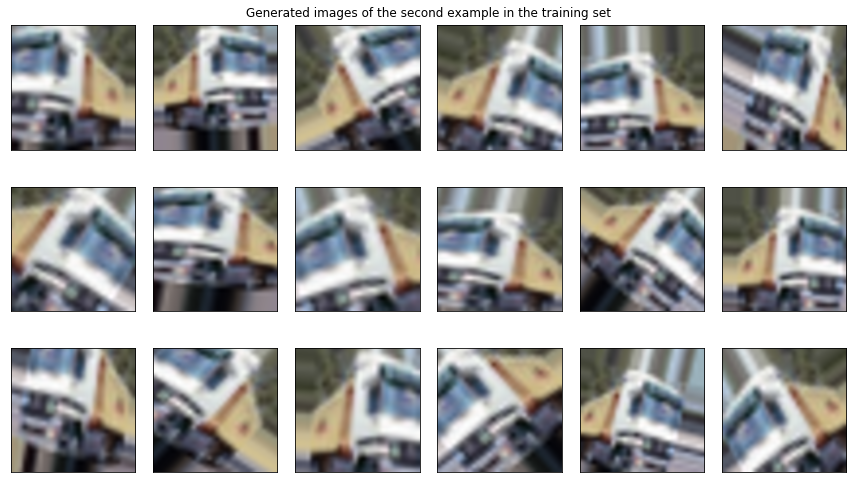

In [23]:
# Define the image generator and set its parameters
idg = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False, 
        fill_mode='nearest',
)

batch = 0
max_batch = 18
img_gen = []

for x_batch in idg.flow(X_1, batch_size=max_batch):
    img_gen.append(x_batch[0])
    batch += 1
    if batch >= max_batch:
        break


plot_generated_img(img_gen, smooth=True)

After checking the generated examples let's fit the training set.

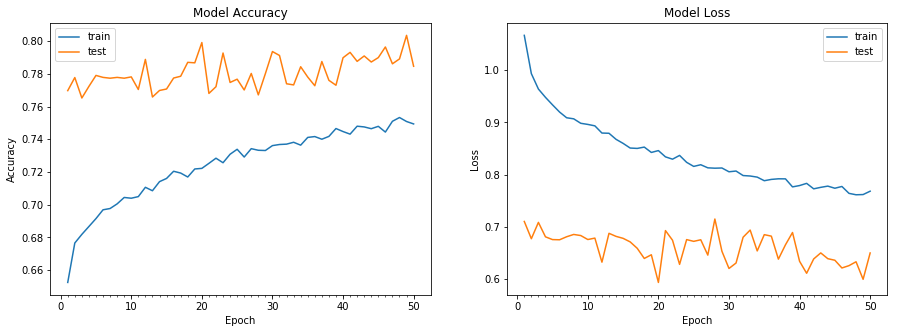

Training time: 936.94 seconds
Accuracy on test data is 78.46


In [24]:
model = model1

#idg = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True)
idg = ImageDataGenerator(
        rotation_range=40,
        #width_shift_range=0.15,
        #height_shift_range=0.15,
        #shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False, 
        fill_mode='nearest',
)

idg.fit(X_train)

# Model Training
start = time.time()
model_info = model.fit_generator(idg.flow(X_train, labels_train, batch_size = 128),
                                 steps_per_epoch = X_train.shape[0] // 128, epochs = 50, 
                                 validation_data = (X_test, labels_test), verbose=0)
end = time.time()

# Plot model history
plot_model_history(model_info)

print('Training time: %0.2f seconds'%(end - start))

# Compute test accuracy
print('Accuracy on test data is %0.2f'%accuracy(X_test, labels_test, model))